In [1]:
import numpy as np
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib as mpl
from tkinter import *
from tkinter import filedialog
from tqdm import notebook
from sklearn.ensemble import RandomForestClassifier

import networkx as nx

In [2]:
def weighted_smoothing(predictions, size):
    predictions_new = predictions.copy()
    group_start = [0]
    group_start = np.hstack((group_start, np.where(np.diff(predictions) != 0)[0] + 1))
    for i in range(len(group_start) - 3):
        if group_start[i + 2] - group_start[i + 1] < size:
            if predictions_new[group_start[i + 2]] == predictions_new[group_start[i]] and \
                    predictions_new[group_start[i]:group_start[i + 1]].shape[0] >= size and \
                    predictions_new[group_start[i + 2]:group_start[i + 3]].shape[0] >= size:
                predictions_new[group_start[i]:group_start[i + 2]] = predictions_new[group_start[i]]
    for i in range(len(group_start) - 3):
        if group_start[i + 1] - group_start[i] < size:
            predictions_new[group_start[i]:group_start[i + 1]] = predictions_new[group_start[i] - 1]
    return predictions_new


def rand_ethogram_plot(new_predictions, soft_assignments, file_idx, length_):

    # initialize
    prefill_array = np.zeros((len(new_predictions[file_idx]), len(np.unique(soft_assignments))))
    
    # color map
    all_c_options = list(mcolors.CSS4_COLORS.keys())
    seed_num = 42
    np.random.seed(seed_num)
    selected_idx = np.random.choice(np.arange(len(all_c_options)), 
                                    len(np.unique(soft_assignments)), 
                                    replace=False)
    default_colors = [all_c_options[s] for s in selected_idx]
    R = np.linspace(0, 1, len(np.unique(soft_assignments)))
    default_colors = plt.cm.Spectral(R)
    
    default_colors_wht = ['w']
    default_colors_wht.extend(default_colors)
    cmap_ = ListedColormap(default_colors_wht)
    
    # binary table
    count = 0
    for b in np.unique(soft_assignments):
        idx_b = np.where(new_predictions[file_idx] == b)[0]
        prefill_array[idx_b, count] = b+1
        count += 1
        
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    seed_num = 42
    np.random.seed(seed_num)
    rand_start = np.random.choice(prefill_array.shape[0] - length_, 1, replace=False)
    ax.imshow(prefill_array[int(rand_start):int(rand_start + length_), :].T, cmap=cmap_)
    ax.set_yticks(np.arange(0, len(np.unique(soft_assignments)), 5), fontsize=14)
    ax.set_yticklabels(np.arange(0, len(np.unique(soft_assignments)), 5), fontsize=14)
    ax.set_ylim(0, len(np.unique(soft_assignments)))
    ax.set_xticks(np.arange(0, length_, int(length_/5)))
    ax.set_xticklabels(np.arange(int(rand_start), int(rand_start + length_), int(length_/5)), fontsize=14)
    ax.set_xlabel('Frame #', fontsize=16)

    return fig, ax, prefill_array, rand_start, length_


def aligned_ethogram_plot(new_predictions, soft_assignments, file_idx, alignedtime, length_):

    # initialize
    prefill_array = np.zeros((len(new_predictions[file_idx]), len(np.unique(soft_assignments))))
    
    # color map
    all_c_options = list(mcolors.CSS4_COLORS.keys())

    R = np.linspace(0, 1, len(np.unique(soft_assignments)))
    default_colors = plt.cm.Spectral(R)
    
    default_colors_wht = ['w']
    default_colors_wht.extend(default_colors)
    cmap_ = ListedColormap(default_colors_wht)
    
    # binary table
    count = 0
    for b in np.unique(soft_assignments):
        idx_b = np.where(new_predictions[file_idx] == b)[0]
        prefill_array[idx_b, count] = b+1
        count += 1
        
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    ax.imshow(prefill_array[int(alignedtime*40 - length_/2):int(alignedtime*40 + length_/2), :].T, 
              cmap=cmap_)
    ax.set_yticks(np.arange(0, len(np.unique(soft_assignments)), 5), fontsize=14)
    ax.set_yticklabels(np.arange(0, len(np.unique(soft_assignments)), 5), fontsize=14)
    ax.set_xticks(np.arange(0, length_, int(length_/5)))
    ax.set_xticklabels(np.arange(int(alignedtime*40 - length_/2), int(alignedtime*40 + length_/2), 
                                 int(length_/5)), fontsize=14)
    ax.vlines(int(length_/2), 0, len(np.unique(soft_assignments)), color='k')
    ax.set_ylim(0, len(np.unique(soft_assignments)))
    ax.set_xlabel('Frame #', fontsize=16)

    return fig, ax, prefill_array, rand_start, length_


def compute_matrix(labels, n):
    tm = [[0] * n for _ in range(n)]
    for (i, j) in zip(labels, labels[1:]):
        tm[i][j] += 1

#     index_not = list(set(np.arange(n)) - set(np.unique(labels)))
    tm_df = pd.DataFrame(tm)
#     tm_df = tm_df.drop(index=index_not, columns=index_not)
    tm_array = np.array(tm_df)
    tm_norm = tm_array / tm_array.sum(axis=1)
    return tm_array, tm_df, tm_norm


class directed_graph:

    def __init__(self, soft_assignments, new_predictions):
        self.soft_assignments = soft_assignments
        self.new_predictions = new_predictions
        self.node_sizes = []
        self.transition_matrix_norm = []

    def compute_dynamics(self, indices):
        # initialize some array
        tm_count_all = []
        tm_prob_all = []
        # for the files you've listed, obtain the transition matrix, append into a list
        for idx in indices:
            tm_array, tm_df, tm_norm = compute_matrix(self.new_predictions[idx],
                                                      len(np.unique(self.soft_assignments)))
            ## raw counts
            tm_count_all.append(tm_array)
            ## normalized probability
            tm_prob_all.append(tm_norm)
        # nan-neglected mean across all files
        print([tm_prob_all[i].shape for i in range(len(tm_prob_all))])
        tm_count_mean = np.nanmean(tm_count_all, axis=0)
        tm_prob_mean = np.nanmean(tm_prob_all, axis=0)
        # rescale probability after losing the self-transition
        diag = [tm_count_mean[i][i] for i in range(len(tm_count_mean))]
        diag_p = np.array(diag) / np.array(diag).max()
        # keep diag to provide information about relative behavioral duration
        # scale it by 50, works well, and save it as a global variable
        self.node_sizes = [50 * i for i in diag_p]
        ## transition matrix from 2d array into numpy matrix for networkx
        transition_matrix = np.matrix(tm_prob_mean)
        # replace diagonal with 0
        np.fill_diagonal(transition_matrix, 0)
        self.transition_matrix_norm = transition_matrix / transition_matrix.sum(axis=1)
        nan_indices = np.isnan(self.transition_matrix_norm)
        self.transition_matrix_norm[nan_indices] = 0
        return self.transition_matrix_norm
    
    
    def plot(self):
        fig = plt.figure()
        # particular networkx graph
        graph = nx.from_numpy_array(self.transition_matrix_norm, create_using=nx.MultiDiGraph())
        # set node position with seed 0 for reproducibility
        node_position = nx.layout.spring_layout(graph, seed=0)
        # edge colors is equivalent to the weight
        edge_colors = [graph[u][v][0].get('weight') for u, v in graph.edges()]
        # node is dependent on the self transitions, which is defined in compute dynamics above, use blue colormap
        nodes = nx.draw_networkx_nodes(graph, node_position, node_size=self.node_sizes,
                                       node_color='blue')
        # edges are drawn as arrows with blue colormap, size 8 with width 1.5
        edges = nx.draw_networkx_edges(graph, node_position, node_size=self.node_sizes, arrowstyle='->',
                                       arrowsize=8, edge_color=edge_colors, edge_cmap=plt.cm.Blues, width=1.5)
        # label position is 0.005 to the right of the node
        label_pos = [node_position[i] + 0.005 for i in range(len(node_position))]
        # draw labels with font size 10
        nx.draw_networkx_labels(graph, label_pos, font_size=10)
        # generate colorbar from the edge colors
        pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
        pc.set_array(edge_colors)
        plt.colorbar(pc)
        ax = plt.gca()
        ax.set_axis_off()
        return fig

    def main(self, indices):
        # runs both
        self.compute_dynamics(indices)
        self.plot()

In [7]:
sampled_features, sampled_embeddings = joblib.load('../data/prelim/Jan-29-2023_final_llh01_embeddings.sav')
_, assignments, _, soft_assignments = joblib.load('../data/prelim/Jan-29-2023_final_llh01_clusters.sav')
folders, folder, filenames, new_data, new_predictions = joblib.load('../data/prelim/all_files_predictions.sav')

## plot random time point ethogram

In [9]:
file_idx = 1
predictions_smoothed = weighted_smoothing(new_predictions[file_idx], size=6)

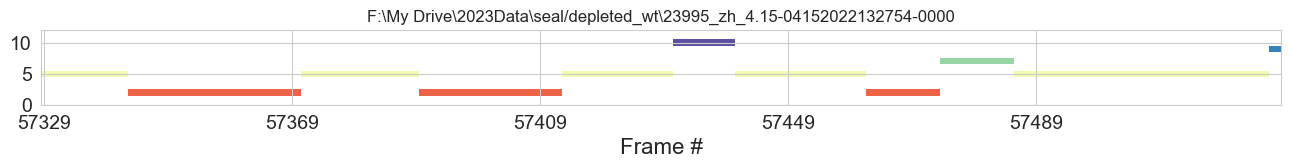

In [10]:
length = 200
fig, ax, prefill_array, rand_start, length_ = rand_ethogram_plot([predictions_smoothed], 
                                                                 soft_assignments, 
                                                                 0, 
                                                                 length)
ax.set_title(filenames[file_idx].rpartition('DLC')[0])
plt.show()

## plot ethogram around hovering

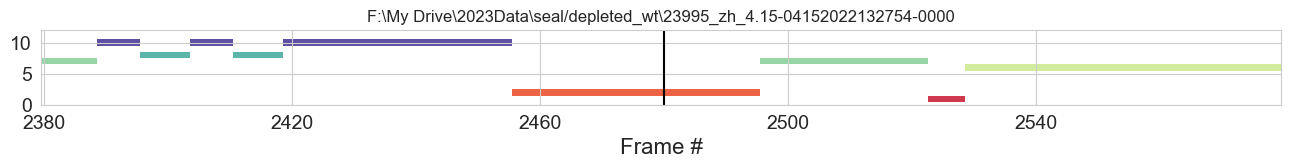

In [11]:
alignedtime = 62
fig, ax, prefill_array, rand_start, length_ = aligned_ethogram_plot([predictions_smoothed], 
                                                                    soft_assignments, 
                                                                    0, 
                                                                    alignedtime, 
                                                                    length)
ax.set_title(filenames[file_idx].rpartition('DLC')[0])
plt.show()

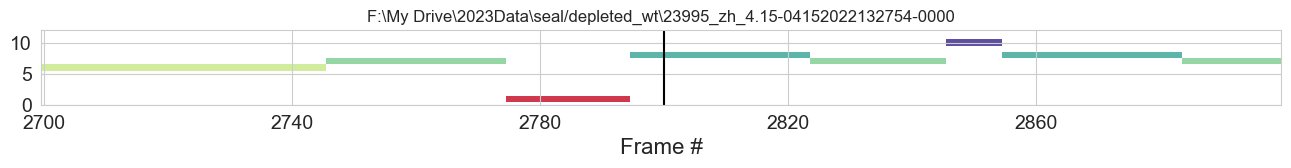

In [12]:
alignedtime = 70
fig, ax, prefill_array, rand_start, length_ = aligned_ethogram_plot([predictions_smoothed], 
                                                                    soft_assignments, 
                                                                    0, 
                                                                    alignedtime, 
                                                                    length)
ax.set_title(filenames[file_idx].rpartition('DLC')[0])
plt.show()

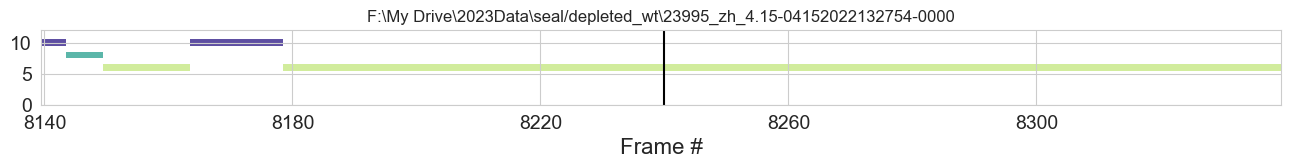

In [13]:
alignedtime = int(3*60 + 26)
fig, ax, prefill_array, rand_start, length_ = aligned_ethogram_plot([predictions_smoothed], 
                                                                    soft_assignments, 
                                                                    0, 
                                                                    alignedtime, 
                                                                    length)
ax.set_title(filenames[file_idx].rpartition('DLC')[0])
plt.show()

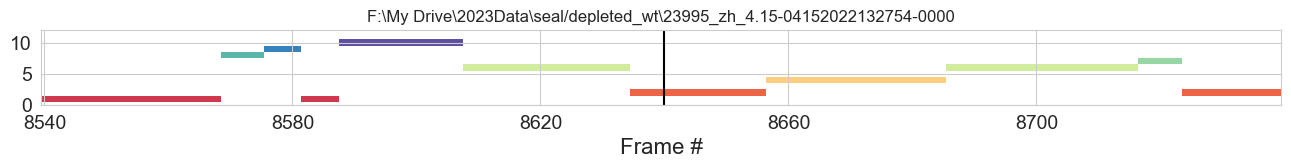

In [14]:
alignedtime = int(3*60 + 36)
fig, ax, prefill_array, rand_start, length_ = aligned_ethogram_plot([predictions_smoothed], 
                                                                    soft_assignments, 
                                                                    0, 
                                                                    alignedtime, 
                                                                    length)
ax.set_title(filenames[file_idx].rpartition('DLC')[0])
plt.show()

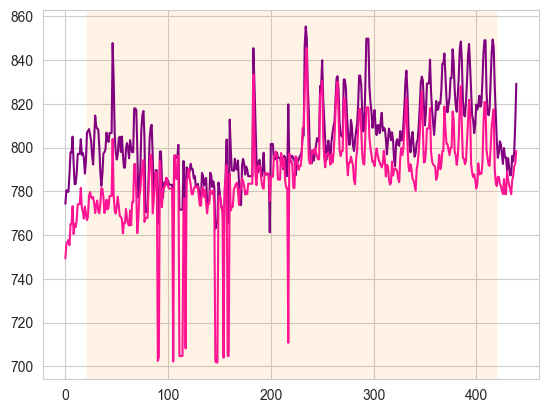

In [15]:
# alignedtimes = [62, 70]
# alignedtimes = [int(3*60 + 26), int(3*60 + 36)]
alignedtimes = [int(4*60 + 7), int(4*60 + 17)]
plt.axvspan(20, 20+(alignedtimes[1]-alignedtimes[0])*40, facecolor='darkorange', alpha=0.1)

plt.plot(new_data[1][int(alignedtimes[0]*40-20):int(alignedtimes[1]*40+20), 2], color='purple')
plt.plot(new_data[1][int(alignedtimes[0]*40-20):int(alignedtimes[1]*40+20), 3], color='deeppink')
plt.show()

In [16]:
# hovering times for 23995 file_idx=1
alignedtimes = [
    [int(1*60 + 2), int(1*60 + 10)], 
    [int(3*60 + 26), int(3*60 + 36)], 
    [int(4*60 + 2), int(4*60 + 17)], 
    [int(8*60 + 48), int(9*60 + 2)],
    [int(11*60 + 37), int(11*60 + 43)], 
    [int(14*60 + 56), int(15*60 + 8)],
    [int(16*60 + 42), int(16*60 + 47)],
               ]
pose_cols = [[2, 3], [4, 5]]

## plot all hovering left/right paw movement


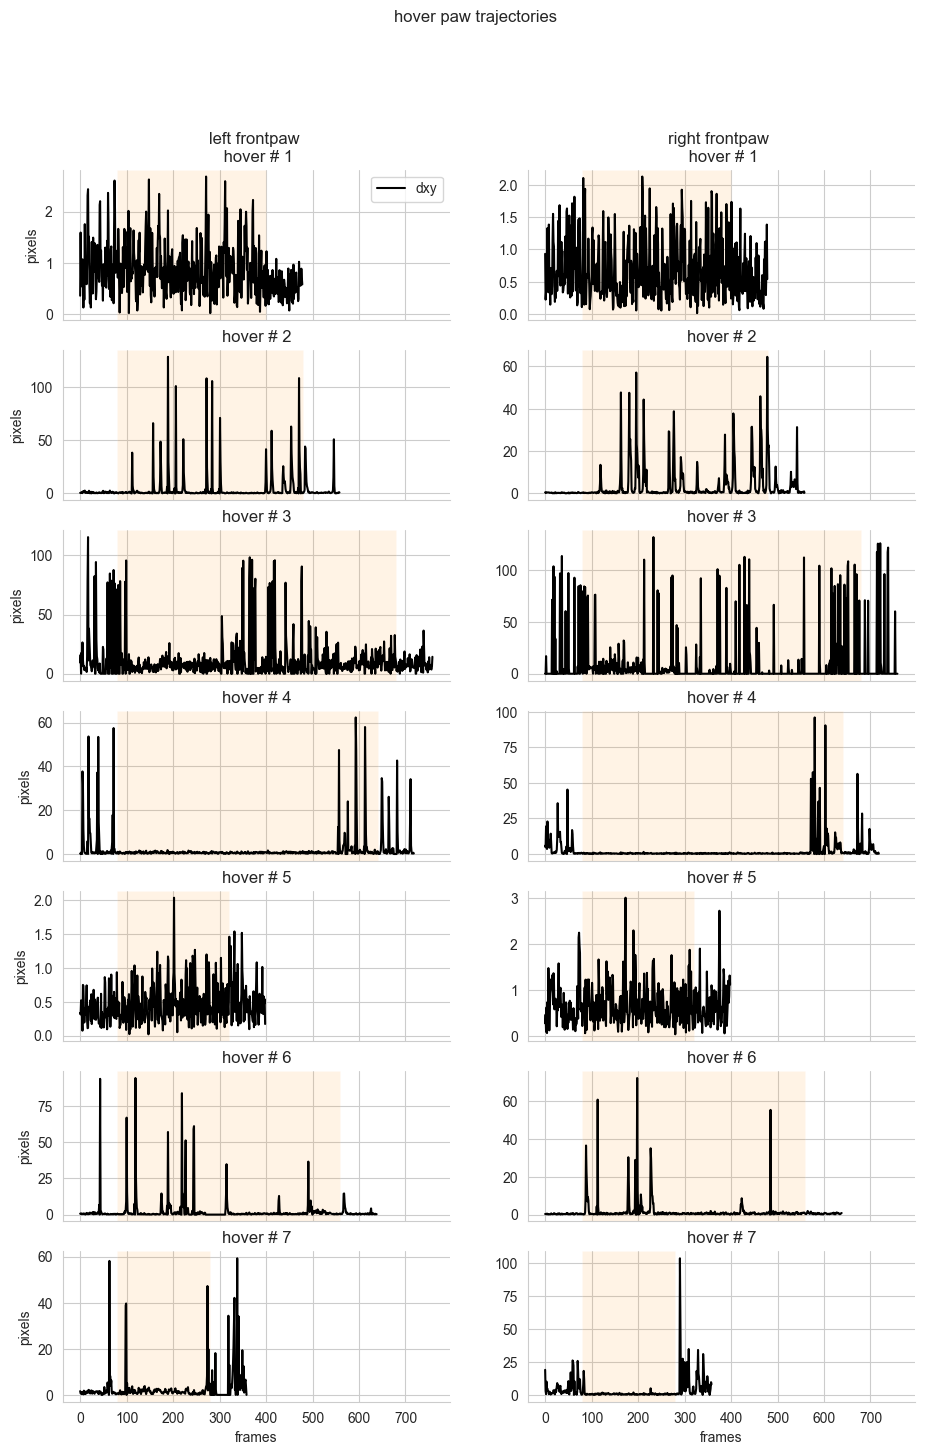

In [17]:
rows = len(alignedtimes)
cols = len(pose_cols)
timebefore = 2
fig, ax = plt.subplots(rows, cols, figsize=(11, 16), sharex=True)
plt.suptitle('hover paw trajectories')
for row in range(rows):
    for col in range(cols):

        ax[row, col].axvspan(timebefore*40, 
                             timebefore*40 + 
                             (alignedtimes[row][1]-alignedtimes[row][0])*40, 
                             facecolor='darkorange', alpha=0.1)
        x = new_data[1][int(alignedtimes[row][0]*40-timebefore*40):
                        int(alignedtimes[row][1]*40+timebefore*40), 
                        pose_cols[col][0]]
        y = new_data[1][int(alignedtimes[row][0]*40-timebefore*40):
                        int(alignedtimes[row][1]*40+timebefore*40), 
                        pose_cols[col][1]]
        
#         ax[row, col].plot(x, 
#                           color='purple', label='x')
#         ax[row, col].plot(y, 
#                           color='deeppink', label='y')
        dx = x[1:]-x[:-1]
        dy = y[1:]-y[:-1]
        step_size = np.sqrt(dx**2+dy**2)
        cumulative_distance = np.concatenate(([0], np.cumsum(step_size)))
#         print(x, y, cumulative_distance)
        ax[row, col].plot(step_size, color='k', label='dxy')
        if col == 0 and row == 0:
            ax[row, col].set_title(f'left frontpaw \n hover # {row+1}')
            ax[row, col].legend()
        elif col == 1 and row == 0:
            ax[row, col].set_title(f'right frontpaw \n hover # {row+1}')
        else:
            ax[row, col].set_title(f'hover # {row+1}')
        ax[row, col].spines[['right', 'top']].set_visible(False)
        if col == 0:
            ax[row, col].set_ylabel('pixels')
        if row == rows-1:
            ax[row, col].set_xlabel('frames')
plt.show()
fig.savefig('../figures/hover_displacement.png', dpi=600)

## compute coincident hovering behavior stats

In [20]:
behavior_names = ['pause', 'sniff_1', 'unknown', 'sniff_2', 'loco_Lfore', 
                  'sniff_3', 'scrunch', 'orientL', 'loco_Rfore', 'bodygroom_rear', 
                  'sniff_4', 'facegroom', 'bodygroom', 'headgroom']

In [21]:

hovering_dict = {'Hover instance': np.hstack([np.repeat(i, 
                                                    int(alignedtimes[i][1]*40)-
                                                    int(alignedtimes[i][0]*40))
                                          for i in range(len(alignedtimes))]), 
                 'Behavior': [behavior_names[j] for j in np.hstack([predictions_smoothed[int(alignedtimes[i][0]*40):
                                                               int(alignedtimes[i][1]*40)] 
                                          for i in range(len(alignedtimes))])]}
hover_df = pd.DataFrame(data=hovering_dict)
hover_df['Behavior'] = pd.Categorical(hover_df['Behavior'], 
                                      ['pause','sniff_1','sniff_2','sniff_3', 'sniff_4', 
                                       'scrunch','facegroom','headgroom','bodygroom', 'bodygroom_rear', 
                                       'orientL','loco_Rfore','loco_Lfore', 'unknown'])
hover_df


,Hover instance,Behavior
0,0,sniff_2
1,0,sniff_2
2,0,sniff_2
3,0,sniff_2
4,0,sniff_2
...,...,...
2795,6,sniff_3
2796,6,sniff_3
2797,6,sniff_3
2798,6,sniff_3


## plot hovering coincident behavior stats

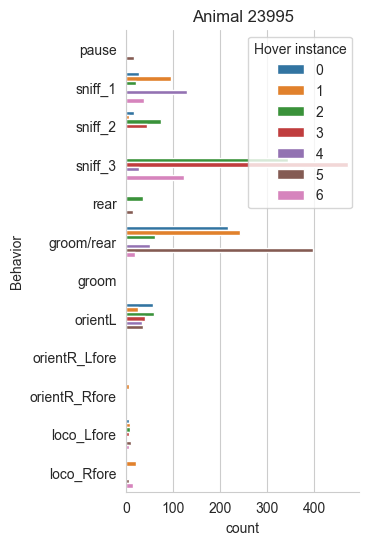

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
sns.countplot(data=hover_df, hue='Hover instance', y='Behavior',
              ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.set_title('Animal 23995')
plt.show()
# fig.savefig('../figures/behavior_histbar.png', dpi=600)

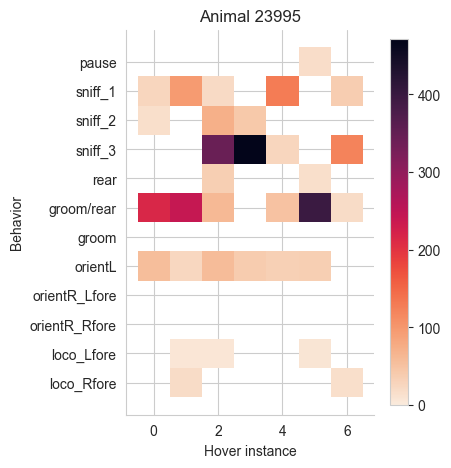

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
sns.histplot(
    hover_df, y="Behavior", x="Hover instance",
    bins=20, discrete=(True, True), log_scale=(False, False),
    cbar=True, cbar_kws=dict(shrink=.95),
    pthresh=.01, pmax=.99,
    cmap="rocket_r", ax=ax
)
ax.set_title('Animal 23995')
ax.spines[['right', 'top']].set_visible(False)
plt.show()
fig.savefig('../figures/behavior_2Dhist_v2.png', dpi=600)
fig.savefig('../figures/behavior_2Dhist_v2.svg', dpi=600)

In [350]:

hovering_dict2 = {'Hover instance': np.hstack([np.repeat(i,
                                                    int(alignedtimes[i][1]*40)-
                                                    int(alignedtimes[i][0]*40))
                                          for i in range(len(alignedtimes))]),
                 'Behavior': np.hstack([predictions_smoothed[int(alignedtimes[i][0]*40):
                                                               int(alignedtimes[i][1]*40)]
                                          for i in range(len(alignedtimes))])}
hover_df2 = pd.DataFrame(data=hovering_dict2)
# hover_df2['Behavior'] = pd.Categorical(hover_df2['Behavior'],
#                                       ['pause','sniff_1','sniff_2','sniff_3', 'sniff_4',
#                                        'scrunch','facegroom','headgroom','bodygroom', 'bodygroom_rear',
#                                        'orientL','loco_Rfore','loco_Lfore', 'unknown'])
hover_df2


,Hover instance,Behavior
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2795,6,6
2796,6,6
2797,6,6
2798,6,6


In [24]:
behavior_during = []
for alignedtime in alignedtimes:
    behavior_during.append(predictions_smoothed[int(alignedtime[0]*40):int(alignedtime[1]*40)])
[n for n in range(len(behavior_during))]

[0, 1, 2, 3, 4, 5, 6]

/var/folders/gp/nsk60k_n2cz7kk79_pv33d8r0000gn/T/ipykernel_66594/3601192567.py:107: RuntimeWarning: invalid value encountered in divide
  tm_norm = tm_array / tm_array.sum(axis=1)
/var/folders/gp/nsk60k_n2cz7kk79_pv33d8r0000gn/T/ipykernel_66594/3601192567.py:134: RuntimeWarning: Mean of empty slice
  tm_prob_mean = np.nanmean(tm_prob_all, axis=0)
/var/folders/gp/nsk60k_n2cz7kk79_pv33d8r0000gn/T/ipykernel_66594/3601192567.py:172: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(pc)


[(12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12)]
[(12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12)]


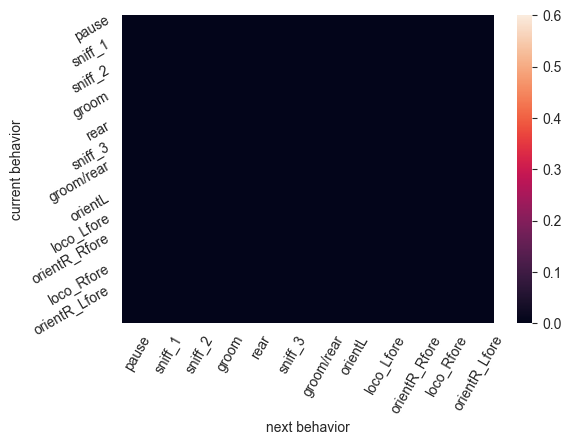

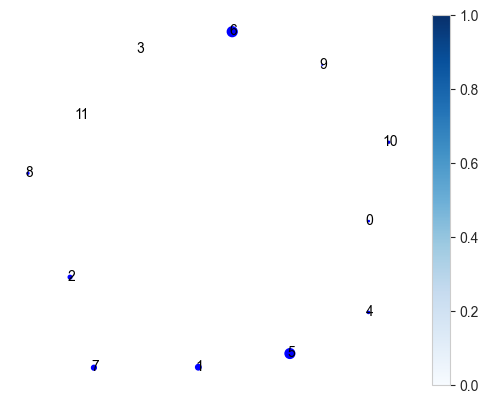

In [25]:
network = directed_graph(soft_assignments, behavior_during)

tmat_norm = network.compute_dynamics([n for n in range(len(behavior_during))])

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.heatmap(tmat_norm, ax=ax,
            vmin=0, vmax=0.6, cbar=True)
ax.set_xlabel('next behavior')
ax.set_ylabel('current behavior')
ax.set_yticklabels(behavior_names, rotation=30)
ax.set_xticklabels(behavior_names, rotation=60)
# plt.show()
# network.plot()
network.main([n for n in range(len(behavior_during))])


# 